In [229]:
cd /home/jsotaloram/active_learning/exp_birds/

/home/jsotaloram/active_learning/exp_birds


In [230]:
import caffe as cf
import os
import sys
from utils_birds import *
sys.path.insert(0, '/home/jsotaloram/software/caffe/python')
import numpy as np
import random 
from pylab import *
%matplotlib inline  

In [231]:
#https://github.com/BVLC/caffe/blob/master/examples/03-fine-tuning.ipynb                                                                               
dataset_path= '/data1/birds/'
birdsFolder = "/data1/birds"
birdsLabels = os.listdir(birdsFolder)
dict_cats = {0:'wood_duck/wod', 1:'egret/egr',2:'owl/owl', 3:'toucan/tou',4:'mandarin/man',5:'puffin/puf'}
#dict_cats = {(k,v) for (k,v) in [(birdsLabels[x],x) for x in range(len(birdsLabels))]}               


In [233]:
cf.set_device(0)
cf.set_mode_gpu()

In [234]:
modelAlexNet = "bvlc_alexnet.caffemodel" #assuming is in the same folder                                                                               
deployProtoTxt = "deploy.prototxt"
imageNetLabels = np.loadtxt("synset_words.txt", str, delimiter='\t')
splitSamples = np.loadtxt("splitSamples.txt", str, delimiter=';')

In [6]:
niter = 200
# losses will also be stored in the log                                                                                                                
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)
# We create a solver that fine-tunes from a previously trained network.                                                                                
solver = cf.SGDSolver('/home/jsotaloram/active_learning/exp_birds/solver_ft.prototxt')
solver.net.copy_from('bvlc_alexnet.caffemodel')


In [9]:
for it in range(niter):
    solver.step(1)  # SGD by Caffe                                                                                                                     
    #scratch_solver.step(1)                                                                                                                            
    # store the train loss                                                                                                                             
    train_loss[it] = solver.net.blobs['loss'].data
    #scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data                                                                                    
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f' % (it, train_loss[it])
print 'done finnetunning!'


iter 0, finetune_loss=0.000018
iter 10, finetune_loss=0.000007
iter 20, finetune_loss=0.000001
iter 30, finetune_loss=0.000029
iter 40, finetune_loss=0.000006
iter 50, finetune_loss=0.000020
iter 60, finetune_loss=0.000002
iter 70, finetune_loss=0.000001
iter 80, finetune_loss=0.000013
iter 90, finetune_loss=0.000000
iter 100, finetune_loss=0.000194
iter 110, finetune_loss=0.000000
iter 120, finetune_loss=0.000000
iter 130, finetune_loss=0.000007
iter 140, finetune_loss=0.000000
iter 150, finetune_loss=0.000001
iter 160, finetune_loss=0.000001
iter 170, finetune_loss=0.000197
iter 180, finetune_loss=0.000002
iter 190, finetune_loss=0.000009
done finnetunning!


In [11]:
#Let's compute the performance measures, first partitionate as required
samples = loadSamples()
woodSamples = np.array(splitSamples[1:, 0], dtype=int) -1
egretSamples = 100*1 + np.array(splitSamples[1:, 1], dtype=int) - 1
owlSamples = 100*2 + np.array(splitSamples[1:, 2], dtype=int) - 1
toucanSamples = 100*3 + np.array(splitSamples[1:, 3], dtype=int) - 1
puffinSamples = 100*4 + np.array(splitSamples[1:, 4], dtype=int) - 1
mandarinSamples = 100*5 + np.array(splitSamples[1:, 5], dtype=int) - 1
trainIdx = np.concatenate((
        woodSamples[0:20],
        egretSamples[0:20],
        owlSamples[0:20],
        toucanSamples[0:20],
        puffinSamples[0:20],
        mandarinSamples[0:20],
        ))

crossIdx = np.concatenate((
        woodSamples[20:50],
        egretSamples[20:50],
        owlSamples[20:50],
        toucanSamples[20:50],
        puffinSamples[20:50],
        mandarinSamples[20:50],
        ))

testIdx = np.concatenate((
        woodSamples[50:100],
        egretSamples[50:100],
        owlSamples[50:100],
        toucanSamples[50:100],
        puffinSamples[50:100],
        mandarinSamples[50:100],
        ))

In [235]:
samples
dict_cats_nameOnly = {0:'wood_duck', 1:'egret',2:'owl', 3:'toucan',4:'mandarin',5:'puffin'}

inv_bird_map_nameOnly = {v: k for k, v in dict_cats_nameOnly.items()}

all_samples_cats = []
for sample in samples:
    all_samples_cats.append(inv_bird_map_nameOnly[sample[0]])
#all_samples_cats

In [236]:
import utils_birds
reload(utils_birds)

num_lbls_test = [all_samples_cats[i] for i in testIdx]
len(num_lbls_test)

300

In [237]:
#Now let's make a forward on the net that we have just finetunned:
YPredAlexNet, feats_fc6, feats_fc7 = predict(solver.net, samples[testIdx])
yTest = samples[testIdx, 0]

ValueError: Mean channels incompatible with input.

In [17]:
inv_bird_map = {v: k for k, v in dict_cats.items()}

pred_cats = []
for bird in YPredAlexNet:
    pred_cats.append(dict_cats[bird[0]].split('/')[0])
predicted_test_cats =   [pred_cats[i] for i in testIdx]
confusion_finetunning = confusion_matrix(yTest,predicted_test_cats, labels=birdsLabels)
#YPredAlexNet

NameError: name 'YPredAlexNet' is not defined

In [238]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (40, 1, 1, 4096)),
 ('label', (40, 1, 1, 1)),
 ('fc7', (40, 32)),
 ('fc8_birds', (40, 6)),
 ('fc8_birds_fc8_birds_0_split_0', (40, 6)),
 ('fc8_birds_fc8_birds_0_split_1', (40, 6)),
 ('prob', (40, 6)),
 ('loss', ())]

In [239]:
for i in range(10):
    print yTest[i],predicted_test_cats[i]

NameError: name 'yTest' is not defined

In [240]:
solver.test_nets[0].blobs['label'].data[:8]

array([[[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]],


       [[[ 0.]]]], dtype=float32)

In [21]:
samples[testIdx]

array([['wood_duck', '/data1/birds/wood_duck/wod037.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod004.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod018.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod027.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod013.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod003.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod034.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod053.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod085.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod005.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod046.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod075.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod083.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod036.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod002.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod048.jpg'],
       ['wood_duck', '/data1/birds/wood_duck/wod091.jpg'

In [ ]:
cd /home/jsotaloram/active_learning/embeddings/tsne_python/

In [ ]:
import numpy as Math
import pylab as Plot
from pandas import DataFrame
from bokeh.plotting import figure, output_notebook, show, vplot
from bokeh.charts import Scatter, show
import tsne
output_notebook()

%matplotlib inline

In [35]:
Y = tsne.tsne(feats_fc7, 2, 50, 20.0,120);

NameError: name 'feats_fc7' is not defined

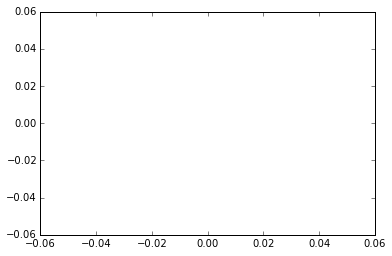

In [119]:
Plot.scatter(Y[:,0], Y[:,1], 20, num_lbls_test);

In [121]:
Y[:]

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,

In [ ]:
import caffe as cf
import os
import sys
import numpy as np
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import caffe as cf
import os
from scipy.special import expit as sigmoid
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import scipy.optimize


In [22]:
pred = np.empty((0,1), dtype=int)
outputLfc6 = np.empty((0,4096))
outputLfc7 = np.empty((0,4096))
transformer = cf.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_mean('data', np.load('/opt/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)


In [23]:
count = 0 
net = solver.net
for sample in samples:
    print count
    count = count+1
    net.blobs['data'].data[...] = transformer.preprocess('data', cf.io.load_image(sample[1]))
    out = net.forward()
    pred = np.concatenate((pred, [net.blobs['fc8_birds'].data[0].flatten().argsort()[-1:-2:-1]]))
    outputLfc6 = np.concatenate((outputLfc6, [net.blobs['fc6'].data[0]]))
    outputLfc7 = np.concatenate((outputLfc7, [net.blobs['fc7'].data[0]]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [31]:
print(np.min(outputLfc7))
print(np.max(outputLfc7))
print(np.var(outputLfc7))
print(np.mean(outputLfc7))
print("====================")
print(np.min(outputLfc6))
print(np.max(outputLfc6))
print(np.var(outputLfc6))
print(np.mean(outputLfc6))


0.0
32.5150337219
2.61357793729
0.410275600715
0.0
105.12651825
22.2349723337
1.10176022573


In [32]:
pwd

u'/home/jsotaloram/active_learning/embeddings/tsne_python'

In [33]:
import cPickle as pickle
pickle.dump([outputLfc6,outputLfc7], open( "feats_alexnet_birdsDS.pkl", "wb" ) )


In [34]:
Y_pca = tsne.pca(outputLfc6,2)

Preprocessing the data using PCA...


(600, 4096)

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/numpy/core/numeric.py:525: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


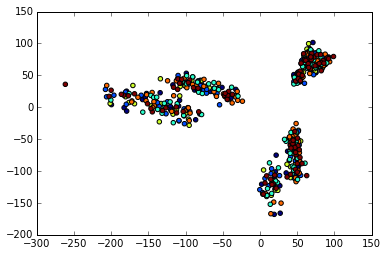

In [39]:
Plot.scatter(Y_pca[:,0], Y_pca[:,1], 20, all_samples_cats);

In [41]:
Y_tsne=tsne.tsne(outputLfc6, 2, 50, 20.0, 110); #110 iterations

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  600 ...
Computing P-values for point  500  of  600 ...
Mean value of sigma:  1.0
Iteration  10 : error is  nan
Iteration  20 : error is  nan
Iteration  30 : error is  nan
Iteration  40 : error is  nan
Iteration  50 : error is  nan
Iteration  60 : error is  nan
Iteration  70 : error is  nan
Iteration  80 : error is  nan
Iteration  90 : error is  nan
Iteration  100 : error is  nan
Iteration  110 : error is  nan


In [39]:
deployProtoTxt = "/home/jsotaloram/active_learning/exp_birds/deploy.prototxt"
modelAlexNet = "/home/jsotaloram/active_learning/exp_birds/bvlc_alexnet.caffemodel"

In [24]:
alexNet = cf.Net(deployProtoTxt, modelAlexNet, cf.TEST)

In [25]:
[(k, v.data.shape) for k, v in alexNet.blobs.items()]

[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('norm1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('norm2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [26]:
!cd /home/jsotaloram/active_learning/exp_birds/
import utils_birds
from utils_birds import *

In [27]:
YPredAlexNet, XLfc6, XLfc7 = predict(alexNet, samples)

In [28]:
import cPickle as pickle
pickle.dump([XLfc6,XLfc7], open( "alexnetFeats_birdsDS_v2.pkl", "wb" ) )


In [66]:
Y_fc6 = tsne.tsne(XLfc6, 2, 50, 20.0, 110); #110 iterations

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  600 ...
Computing P-values for point  500  of  600 ...
Mean value of sigma:  2.38330729708
Iteration  10 : error is  nan
Iteration  20 : error is  nan
Iteration  30 : error is  nan
Iteration  40 : error is  nan
Iteration  50 : error is  nan
Iteration  60 : error is  nan
Iteration  70 : error is  nan
Iteration  80 : error is  nan
Iteration  90 : error is  nan
Iteration  100 : error is  nan
Iteration  110 : error is  nan


In [29]:
XTrainLfc6 = XLfc6[trainIdx]
yTrainLfc6 = samples[trainIdx, 0]
XCrossLfc6 = XLfc6[crossIdx]
yCrossLfc6 = samples[crossIdx, 0]
XTestLfc6 = XLfc6[testIdx]
yTestLfc6 = samples[testIdx, 0]

In [30]:
from scipy.special import expit as sigmoid
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import scipy.optimize


In [31]:
linSvmLfc6 = svm.LinearSVC()
linSvmLfc6.fit(XTrainLfc6, yTrainLfc6)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [32]:
yPredSvmLfc6 = linSvmLfc6.predict(XTestLfc6)

In [33]:
CMSvmLfc6 = confusion_matrix(yTestLfc6, yPredSvmLfc6, labels=birdsLabels)

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


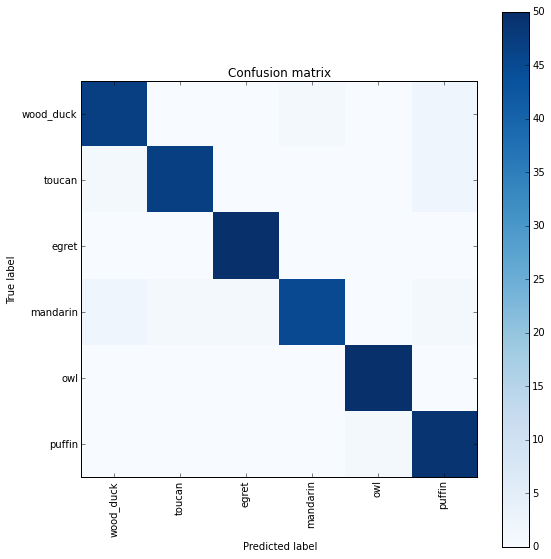

In [34]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(CMSvmLfc6, labels=birdsLabels)

In [51]:
print(classification_report(yTestLfc6, yPredSvmLfc6))

             precision    recall  f1-score   support

      egret       0.98      1.00      0.99        50
   mandarin       0.98      0.90      0.94        50
        owl       0.98      1.00      0.99        50
     puffin       0.91      0.98      0.94        50
     toucan       0.98      0.94      0.96        50
  wood_duck       0.94      0.94      0.94        50

avg / total       0.96      0.96      0.96       300



In [35]:
XTrainLfc7 = XLfc7[trainIdx]
yTrainLfc7 = samples[trainIdx, 0]
XCrossLfc7 = XLfc7[crossIdx]
yCrossLfc7 = samples[crossIdx, 0]
XTestLfc7 = XLfc7[testIdx]
yTestLfc7 = samples[testIdx, 0]

In [36]:
linSvmLfc7 = svm.LinearSVC()
linSvmLfc7.fit(XTrainLfc7, yTrainLfc7)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [37]:
yPredSvmLfc7 = linSvmLfc7.predict(XTestLfc7)

In [38]:
CMSvmLfc7 = confusion_matrix(yTestLfc7, yPredSvmLfc7, labels=birdsLabels)

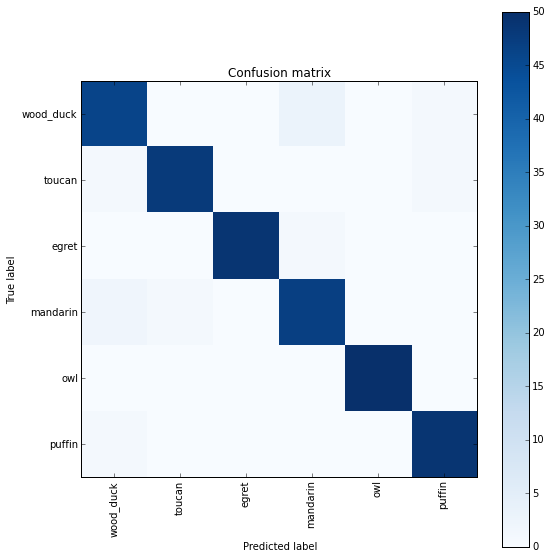

In [39]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(CMSvmLfc7, labels=birdsLabels)

In [57]:
print(classification_report(yTestLfc7, yPredSvmLfc7))

             precision    recall  f1-score   support

      egret       1.00      0.98      0.99        50
   mandarin       0.92      0.94      0.93        50
        owl       1.00      1.00      1.00        50
     puffin       0.96      0.98      0.97        50
     toucan       0.98      0.96      0.97        50
  wood_duck       0.92      0.92      0.92        50

avg / total       0.96      0.96      0.96       300



In [241]:
import caffe as cf

In [242]:
solverPrototxt='/home/jsotaloram/active_learning/exp_birds/protos/solver_proto_lr2_wd0.001_birds.prototxt'
deployPrototxt='/home/jsotaloram/active_learning/exp_birds/protos/proto_lr2_wd0.001_birds.prototxt'
cf.set_mode_gpu()


In [243]:
train_size = 120
val_size = 180
test_size = 300
data4D = np.zeros([train_size ,1,1,4096],np.float32)
data4DL = np.zeros([train_size ,1,1,1], np.float32)
data4D_val = np.zeros([val_size ,1,1,4096],np.float32)
data4DL_val = np.zeros([val_size ,1,1,1], np.float32)
data4D_test = np.zeros([test_size ,1,1,4096],np.float32)
data4DL_test = np.zeros([test_size ,1,1,1], np.float32)

full_idx_range = np.arange(train_size)

In [244]:
#print(full_idx_range)
#np.random.shuffle(full_idx_range)
#np.random.shuffle(full_idx_range_val)
#np.random.shuffle(full_idx_range_test)

#print(full_idx_range)


In [245]:
inv_bird_map_nameOnly = {v: k for k, v in dict_cats_nameOnly.items()}
inv_bird_map_nameOnly['wood_duck']
yTrainLfc7_labels = [inv_bird_map_nameOnly[i] for i in yTrainLfc7]
yTestLfc7_labels = [inv_bird_map_nameOnly[i] for i in yTestLfc7]


In [519]:

Xrs = XTrainLfc7.reshape(train_size,1,1,4096)
Yrs = np.array(yTrainLfc7_labels).reshape(train_size,1,1,1)

#Xval = XCrossLfc7.reshape(val_size,1,1,4096)
#Yval = np.array(yCrossLfc6_labels).reshape(val_size,1,1,1)

Xtest = np.array(XTestLfc7).reshape(test_size,1,1,4096)
Ytest = np.array(yTestLfc7_labels).reshape(test_size,1,1,1)

data4D[0:120,:,:,:]  = [Xrs[train_idx] for train_idx in range(120)]
data4DL[0:120,:,:,:] = [Yrs[train_idx] for train_idx in range(120)]

data4D_toy = data4D[0].reshape(1,1,1,4096)
data4DL_toy = data4DL[0].reshape(1,1,1,1)

#data4D_val[0:180,:,:,:]  = [Xval[val_idx] for val_idx in val_idx]
#data4DL_val[0:180,:,:,:] = [Yval[val_idx] for val_idx in full_idx_range_val]

data4D_test[0:300,:,:,:]  = [Xtest[test_idx] for test_idx in range(300)]
data4DL_test[0:300,:,:,:] = [Ytest[test_idx] for test_idx in range(300)]

print data4D_toy

[[[[ 0.          0.          1.18869257 ...,  0.          0.          0.        ]]]]


In [600]:
def set_single_sample(num_sampl):
    return (data4D[num_sampl].reshape(1,1,1,4096), data4DL[num_sampl].reshape(1,1,1,1))

print set_toy_sample(num_sampl)[0].shape
def set_singleTest_sample(num_sampl):
    return (data4D_test[num_sampl].reshape(1,1,1,4096), data4DL_test[num_sampl].reshape(1,1,1,1))

print(np.sum(set_singleTest_sample(10)[0]))


(1, 1, 1, 4096)
2040.2


In [247]:

full_idx_range = np.arange(train_size)
full_idx_range_val = np.arange(val_size)
full_idx_range_test = np.arange(test_size)

learning_rates_pool = [0.0001,0.0003, 0.001,0.005,0.01,0.1,0.5,0.8,1,2,4]
decay_mult = [0.0001,0.001,0.005, 0.01,0.1,0.5, 1,5,2,10,100]
hyper_params_combs = [] 
for lr_item in learning_rates_pool:
    for dec_item in decay_mult:
        #print 'combination of lr: ' + str(lr_item) +' and decay: ' +str(dec_item) + '\n'
        hyper_params_combs.append((lr_item,dec_item))


In [451]:
# Here will be described each of the nessesarly methods:
#solver.net.forward() compute the ['prob'] and the ['loss'] for the current bach of samples
#solver.net.backward() Backward pass: prepare diffs and run the net backward. 
#solver.net.backward(diffs=['fc8_birds'])['fc8_birds'].shape
#solver.net.blobs.items()
niter = 10000
num_classes = 6
batch_nsize = solver.net.blobs['data'].data.shape[0]
num_hidn = solver.net.blobs['fc7'].data.shape[1]
grad_layers = 1 #only taking into account fc7 and fc8_birds
#print(solver.net.forward()['prob'].shape)
net_fwrds = {}
net_fwrds['fc7'] = np.zeros((niter, batch_nsize, num_classes)) #(10000, 2, 40, 32) 
net_bkwrds = {}
net_bkwrds['fc7'] = np.zeros(niter)

#print(solver.net.backward(diffs=['fc8_birds'])['fc8_birds'].shape[0])
#solver.net.forward(blobs=[])

#print ('Training with batch size of ' + str(batch_nsize))
#print ('net_fwrds shape es ' + str(net_fwrds['fc7'].shape))
#net_fwrds['fc7'][0,0] =  solver.net.forward()['prob'].flatten()
#print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
#print(solver.net.backward())
print(np.sum(data4D[0,:,:,:]))
solver.net.blobs['data'].data

1791.34


array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)

In [558]:
(lr_i,wd_i) = (2,0.001)
temp_solver_path = save_protos_path+'solver_proto_lr'+str(lr_i)+'_wd'+str(wd_i)+'_birds.prototxt'
net_fwrds = {}
net_fwrds['fc7'] = np.zeros((niter, batch_nsize, num_classes)) #(10000, 2, 40, 32) 
net_bkwrds = {}
net_bkwrds['fc7'] = np.zeros(niter)
it = 0

solver = cf.SGDSolver(temp_solver_path)
solver.net.set_input_arrays(set_single_sample(num_sampl)[0], set_single_sample(num_sampl)[1])
solver.test_nets[0].set_input_arrays(data4D_test,data4DL_test)
#print(np.sum(solver.net.inputs))
#net_fwrds['fc7'][it,batch_nsize-1] = solver.net.forward()['prob'].flatten()
#print(net_fwrds['fc7'][it,batch_nsize-1])
#np.sum(solver.net.blobs['data'].data[...])
#print(solver.net.params[])
#print(solver.net.backward(diffs=['fc7'])['fc7'])
#solver.net.inputs
#print(solver.net.forward()['prob'].flatten())

net_fwrds['fc7'][it,batch_nsize-1] = solver.net.forward()['prob'].flatten()
print(net_fwrds['fc7'][it,batch_nsize-1])
print(solver.net.backward(diffs=['fc7'])['fc7'])
print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
solver.step(1)
pred_labels_test_birds = []
test_net = solver.test_nets[0] 
output = test_net.forward()
for i in range(300):
    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
print 'f1 so far: ' + str(cr_f1[-2])

solver.net.set_input_arrays(set_single_sample(90)[0], set_single_sample(90)[1])
print(net_fwrds['fc7'][it,batch_nsize-1])
print(solver.net.backward(diffs=['fc7'])['fc7'])
print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
solver.step(1)
pred_labels_test_birds = []
output = test_net.forward()
for i in range(300):
    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
print 'f1 so far: ' + str(cr_f1[-2])



solver.net.set_input_arrays(set_single_sample(50)[0], set_single_sample(50)[1])
print(net_fwrds['fc7'][it,batch_nsize-1])
print(solver.net.backward(diffs=['fc7'])['fc7'])
print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
solver.step(1)
pred_labels_test_birds = []
test_net = solver.test_nets[0] 
output = test_net.forward()
for i in range(300):
    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
print 'f1 so far: ' + str(cr_f1[-2])



solver.net.set_input_arrays(set_single_sample(78)[0], set_single_sample(78)[1])
print(net_fwrds['fc7'][it,batch_nsize-1])
print(solver.net.backward(diffs=['fc7'])['fc7'])
print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
solver.step(1)
pred_labels_test_birds = []
test_net = solver.test_nets[0] 
output = test_net.forward()
for i in range(300):
    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
print 'f1 so far: ' + str(cr_f1[-2])


#print(solver.net.forward()['prob'].flatten())
#print(solver.net.forward()['prob'].flatten())
#for layer in solver.net.layers:
#    print layer
#    for blob in layer.blobs:
#        print blob
        #blob.data[...] -= blob.diff
#        print(blob.data[...].shape)


[ 0.18148656  0.16088147  0.16825493  0.17059448  0.16902225  0.14976026]
[[-0.00038674  0.00968746 -0.0205188  -0.00367535 -0.01200717  0.00719258
   0.00295646 -0.00871575  0.01003674  0.00276687  0.00283858 -0.00140541
   0.00661991 -0.00483315 -0.00847466 -0.00794144  0.01504628 -0.00935124
  -0.00867611 -0.008472   -0.0108938  -0.00027574 -0.00893286  0.0013509
   0.00575821  0.0007013   0.00194938  0.01585026 -0.0149168   0.0056632
   0.0104617  -0.00659172]]
0.0498703
f1 so far: 0.05
[ 0.18148656  0.16088147  0.16825493  0.17059448  0.16902225  0.14976026]
[[ -1.28473872e-02  -9.68193461e-04  -2.66418159e-02  -6.43217470e-03
   -2.01762803e-02  -1.15049891e-02  -9.20358070e-06  -1.89380031e-02
    6.05948549e-03  -2.85928906e-03  -3.32369376e-03  -8.41375161e-03
    1.17342372e-03  -2.99066165e-03  -1.47584127e-02  -2.17035376e-02
    2.46055133e-04  -1.57397296e-02  -1.84308719e-02  -2.45185848e-02
   -2.53042299e-02  -6.31075166e-03  -1.22305956e-02  -1.12435101e-02
   -7.4056

In [488]:
net_fwrds['fc7'][it,batch_nsize-1] = solver.net.forward()['prob'].flatten()
print(net_fwrds['fc7'][it,batch_nsize-1])

print(solver.net.backward(diffs=['data'])['data'])

[ 0.15922825  0.17658813  0.14932318  0.16345574  0.18470168  0.166703  ]
[[[[ -2.06137891e-04  -1.42721867e-04   2.50571553e-04 ...,
     -2.80772338e-06   2.92665762e-04   3.92636226e-04]]]]


In [559]:
net_fwrds['fc7'][it,batch_nsize-1] = solver.net.forward()['prob'].flatten()

In [561]:
cur_sumple = random.randint(1,11) 
save_protos_path = '/home/jsotaloram/active_learning/exp_birds/protos/'
samples_used = []
# All params save and updts based on http://caffe.berkeleyvision.org/tutorial/forward_backward.html
for (lr_i,wd_i) in [(2,0.001)]:# hyper_params_combs[0:50]:
    temp_solver_path = save_protos_path+'solver_proto_lr'+str(lr_i)+'_wd'+str(wd_i)+'_birds.prototxt'
    print 'computing performance for solver: ' + temp_solver_path
    solver = cf.SGDSolver(temp_solver_path)
    train_loss = np.zeros(niter)
    test_loss = np.zeros(niter)
    scratch_train_loss = np.zeros(niter)

    #solver.net.set_input_arrays(data4D, data4DL)
    solver.test_nets[0].set_input_arrays(data4D_test,data4DL_test)

#It seems that labels should be of dimension (n, 1, 1, 1) for memory layer as well.

    for it in range(niter):
        #Accumulating the gradients and probs
        cur_sumple = random.randint(0,119)
        samples_used.append(cur_sumple)
        solver.net.set_input_arrays(set_single_sample(cur_sumple)[0], set_single_sample(cur_sumple)[1])
  
        solver.net.blobs
        net_fwrds['fc7'][it,batch_nsize-1] = solver.net.forward()['prob'].flatten()
        net_bkwrds['fc7'][it] = np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']) 
        solver.step(1)  # SGD by Caffe
        #scratch_solver.step(1)                                                                                                                            
        # store the train loss                                                                                                                             
        train_loss[it] = solver.net.blobs['loss'].data
        #scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data                                                                                    
        test_loss[it] = solver.test_nets[0].blobs['loss'].data

        #if it % 10 == 0:
            #print 'iter %d, Training_Birds: hidden_%d_MLP_loss=%f' % (it,num_hidden_neurons, train_loss[it])
    #print 'done Training!'


    #reporting classification meassures of the small net:
    test_net = solver.test_nets[0] # more than one test net is supported

    test_net.set_input_arrays(data4D_test, data4DL_test)

    pred_labels_test_birds = []

    output = test_net.forward()

    for i in range(300):
        pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])

#CMSvmLfc7 = confusion_matrix(yTestLfc6_labels, pred_labels_test_birds, labels=birdsLabels)
#plt.figure(figsize=(8, 8))
#plot_confusion_matrix(CMSvmLfc7, labels=birdsLabels)

    #print(classification_report(yTestLfc6_labels, pred_labels_test_birds))
    cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
    print 'f1 so far: ' + str(cr_f1[-2])


#print solver.net.blobs['label'].data[29]
#output = solver.net.forward()
#print data4DL_test[29]
#output['prob'][29]
print train_loss
l_T = [yTestLfc7_labels[i] for i in full_idx_range_test]
print pred_labels_test_birds[0:30]
print l_T[0:30]

computing performance for solver: /home/jsotaloram/active_learning/exp_birds/protos/solver_proto_lr2_wd0.001_birds.prototxt
f1 so far: 0.94
[  1.76105452e+00   1.33183932e+00   2.16452694e+00 ...,   1.52041810e-03
   4.51558977e-02   1.13820620e-01]
[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [575]:
test_net.forward()['prob'].flatten()
set_single_sample(cur_sumple)
test_net.forward()['prob'].flatten()[2]*test_net.forward()['prob'].flatten()[2]

0.0036826192

In [597]:
#lets learn with a few GT samples first
num_init_queries = 200
num_active_queries = 200
samples_used = []
active_samples_used = []
probs_sampls = []
paramgrads_sampls = []
expected_value_samples = []
temp_solver_path = save_protos_path+'solver_protoTest_lr'+str(lr_i)+'_wd'+str(wd_i)+'_birds.prototxt'
solver = cf.SGDSolver(temp_solver_path)
train_loss = np.zeros(niter)
test_loss = np.zeros(niter)

#solver.net.set_input_arrays(data4D, data4DL)
solver.test_nets[0].set_input_arrays(set_single_sample(10)[0], set_single_sample(10)[1])
#print([(k, v.data.shape) for k, v in solver.test_nets[0].blobs.items()])

#lets update the params:
for it in range(num_init_queries):
    cur_sumple = random.randint(0,119)
    samples_used.append(cur_sumple)
    solver.net.set_input_arrays(set_single_sample(cur_sumple)[0], set_single_sample(cur_sumple)[1])
    #print(net_fwrds['fc7'][it,batch_nsize-1])
    #print(solver.net.backward(diffs=['fc7'])['fc7'])
    #print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
    solver.step(1)
    pred_labels_test_birds = []
    test_net = solver.test_nets[0] 
    output = test_net.forward()
    #for i in range(300):
    #    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
    #cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
    #print 'f1 so far: ' + str(cr_f1[-2])
    
#Now actively compute which samples should be used for further params updates
for it in range(num_active_queries):
    test_net = solver.test_nets[0] 
    cur_sumple = random.randint(0,119)
    active_samples_used.append(cur_sumple)
    sum_expected_vals_cur = 0
    for lbl in range(6):
        solver.test_nets[0].set_input_arrays(set_single_sample(cur_sumple)[0], np.array([[[[ lbl]]]], np.float32))
        solver.net.set_input_arrays(set_single_sample(cur_sumple)[0], np.array([[[[ lbl]]]], np.float32)) #which lbl gives more info
        probs_sampls.append(test_net.forward()['prob'].flatten())
        sum_expected_vals_cur +=test_net.forward()['prob'].flatten()[lbl]*np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7'])
        paramgrads_sampls.append(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
    expected_value_samples.append(sum_expected_vals_cur)
    
    #print(net_fwrds['fc7'][it,batch_nsize-1])
    #print(solver.net.backward(diffs=['fc7'])['fc7'])
    #print(np.linalg.norm(solver.net.backward(diffs=['fc7'])['fc7']))
    #solver.step(1)
    #pred_labels_test_birds = []
    #test_net = solver.test_nets[0] 
    #output = test_net.forward()
    #for i in range(300):
    #    pred_labels_test_birds.append(test_net.blobs['prob'].data[i].flatten().argsort()[-1:-2:-1][0])
    #cr_f1 = classification_report(yTestLfc7_labels, pred_labels_test_birds).split()
    #print 'f1 so far: ' + str(cr_f1[-2])

print('=====================')
actv_smpls_values = zip(active_samples_used, expected_value_samples)
actv_smpls_values = sorted(actv_smpls_values, key=lambda x: x[1])
active_samples_updt_params = [actv_smpls_values[-k][0] for k in range(1,20)]
print(actv_smpls_values)
print('======================')
print(active_samples_updt_params)
#Now compare the performance of training with the actively selected samples vs a random selection
solver_active_learning = solver
solver_random_selection = solver
for it in range(len(active_samples_updt_params)):
    cur_sumple = active_samples_updt_params[it]
    solver_active_learning.net.set_input_arrays(set_single_sample(cur_sumple)[0], set_single_sample(cur_sumple)[1])
    solver_active_learning.step(1)

for it in range(len(active_samples_updt_params)):
    cur_sumple = random.randint(0,119)
    solver_random_selection.net.set_input_arrays(set_single_sample(cur_sumple)[0], set_single_sample(cur_sumple)[1])
    solver_random_selection.step(1)

pred_labels_test_birds_rs = []
pred_labels_test_birds_al = []

for test_sample in full_idx_range_test:
    solver_active_learning.test_nets[0].set_input_arrays(set_singleTest_sample(test_sample)[0],set_singleTest_sample(test_sample)[1])
    solver_random_selection.test_nets[0].set_input_arrays(set_singleTest_sample(test_sample)[0],set_singleTest_sample(test_sample)[1])
    
    outputRS = solver_random_selection.test_nets[0].forward()
    outputAL = solver_active_learning.test_nets[0].forward()
    pred_labels_test_birds_rs.append(solver_random_selection.test_nets[0].blobs['prob'].data[test_sample].flatten().argsort()[-1:-2:-1][0])
    pred_labels_test_birds_al.append(solver_active_learning.test_nets[0].blobs['prob'].data[test_sample].flatten().argsort()[-1:-2:-1][0])
    
    

[(78, 0.0019550457966561671), (59, 0.0019550458545731231), (59, 0.0019550458545731231), (59, 0.0019550458545731231), (59, 0.0019550458545731231), (59, 0.0019550458545731231), (33, 0.0019550458784663716), (33, 0.0019550458784663716), (33, 0.0019550458784663716), (33, 0.0019550458784663716), (86, 0.0019550458823188455), (119, 0.0019550458888915045), (24, 0.0019550458904529222), (24, 0.0019550458904529222), (24, 0.0019550458904529222), (24, 0.0019550458904529222), (54, 0.0019550459067059264), (77, 0.001955045910563058), (77, 0.001955045910563058), (77, 0.001955045910563058), (77, 0.001955045910563058), (77, 0.001955045910563058), (1, 0.001955045919658005), (82, 0.0019550459224078054), (82, 0.0019550459224078054), (82, 0.0019550459224078054), (82, 0.0019550459224078054), (82, 0.0019550459224078054), (75, 0.0019550459260244679), (75, 0.0019550459260244679), (75, 0.0019550459260244679), (93, 0.0019550459407067233), (89, 0.0019550459447269519), (89, 0.0019550459447269519), (89, 0.001955045944

In [254]:
#Save the model: 
solver.net.save('/home/jsotaloram/active_learning/exp_birds/models/model_small_birds.caffemodel')

In [69]:
# Now finally the active learning algorithm: Expected Gradient Cost
#1) Saving the gradients in each iteration


In [442]:
#TODO: To know which data sample corresponds to which 

array([[  9.32075345e-05,   9.34407294e-01,   1.04461545e-02,
          6.37489650e-03,   4.39701974e-02,   4.70823282e-03]])